## Gaussian Process Regression

Gaussian Processes (GPs) define a prior over functions that can be updated to a posterior once we have observed data. In a supervised setting, the function gives a mapping between the data points $x_i$ and the target value $y_i = f(x_i)$. Gaussian processes infer a distribution over functions given the data $p(f|x,y)$ and then use it to make predictions given new data. A GP assumes that the function is defined at a finite and arbitrary chosen set of points $x_1,...,x_n$ such that $p(f(x_1),...,f(x_n))$ is jointly Gaussian with mean $\mu(x)$ and covariance $\Sigma(x)$, where $\Sigma_{ij} = \kappa(x_i, x_j)$ and $\kappa$ is a positive definite kernel function. Assuming the observations are noiseless, we want to predict the function outputs $y_{\ast} = f(x_{\ast})$. Consider the following joint GP distribution:

\begin{equation}
\left( \begin{array}{c}
f\\
f_{\ast} \end{array} \right)
\sim
N \bigg(\left( \begin{array}{c}
\mu\\
\mu_{\ast} \end{array} \right),
\left( \begin{array}{cc}
K & K_{\ast}\\
K_{\ast}^{T} & K_{\ast\ast} \end{array} \right) \bigg)
\end{equation}

where $K=\kappa(X,X)$, $K_{\ast}=\kappa(X,X_{\ast})$ and $K_{\ast\ast}=\kappa(X_{\ast}, X_{\ast})$. Using standard rules for conditioning Gaussians, the posterior has the following form:

\begin{eqnarray}
    p(f_{\ast}|X_{\ast}, X, f) &\sim& N(f_{\ast}|\mu_{\ast},\Sigma_{\ast})\\
    \mu_{\ast} &=& \mu(X_{\ast}) + K_{\ast}^{T}K^{-1}(f-\mu(X))\\
    \Sigma_{\ast} &=& K_{\ast\ast} - K_{\ast}^{T}K^{-1}K_{\ast}
\end{eqnarray}


Let's start by importing the libraries and defining GP regression class

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

np.random.seed(42)

In [2]:
class GPreg:
    
    def __init__(self, X_train, y_train, X_test):        

        self.L = 1.0
        self.keps = 1e-8
        
        self.muFn = self.mean_func(X_test)
        self.Kfn = self.kernel_func(X_test, X_test) + 1e-15*np.eye(np.size(X_test))
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
            
    def mean_func(self, x):
        muFn = np.zeros(len(x)).reshape(-1,1)
        return muFn
        
    def kernel_func(self, x, z):                
        sq_dist = cdist(x/self.L, z/self.L, 'euclidean')**2
        Kfn = 1.0 * np.exp(-sq_dist/2)
        return Kfn
    
    def compute_posterior(self):
        K = self.kernel_func(self.X_train, self.X_train)  #K
        Ks = self.kernel_func(self.X_train, self.X_test)  #K_*
        Kss = self.kernel_func(self.X_test, self.X_test) + self.keps*np.eye(np.size(self.X_test))  #K_**
        Ki = np.linalg.inv(K) #O(Ntrain^3)        
        
        postMu = self.mean_func(self.X_test) + np.dot(np.transpose(Ks), np.dot(Ki, (self.y_train - self.mean_func(self.X_train))))
        postCov = Kss - np.dot(np.transpose(Ks), np.dot(Ki, Ks))
        
        self.muFn = postMu
        self.Kfn = postCov            

        return None    
    
    def generate_plots(self, X, num_samples=3):
        plt.figure()
        for i in range(num_samples):
            fs = self.gauss_sample(1)
            plt.plot(X, fs, '-k')
            #plt.plot(self.X_train, self.y_train, 'xk')
                
        mu = self.muFn.ravel()
        S2 = np.diag(self.Kfn)
        plt.fill(np.concatenate([X, X[::-1]]), np.concatenate([mu - 2*np.sqrt(S2), (mu + 2*np.sqrt(S2))[::-1]]), alpha=0.2, fc='b')
        plt.show()    
        
    def gauss_sample(self, n):
        # returns n samples from a multivariate Gaussian distribution
        # S = AZ + mu        
        A = np.linalg.cholesky(self.Kfn)
        Z = np.random.normal(loc=0, scale=1, size=(len(self.muFn),n))
        S = np.dot(A,Z) + self.muFn        
        return S    


In [3]:
# generate noise-less training data
X_train = np.array([-4, -3, -2, -1, 1])
X_train = X_train.reshape(-1,1)
y_train = np.sin(X_train)

# generate  test data
X_test = np.linspace(-5, 5, 50)
X_test = X_test.reshape(-1,1)

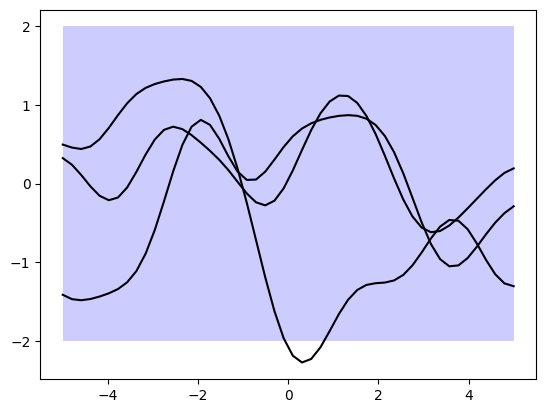

In [4]:
gp = GPreg(X_train, y_train, X_test)
gp.generate_plots(X_test,3)  #samples from GP prior

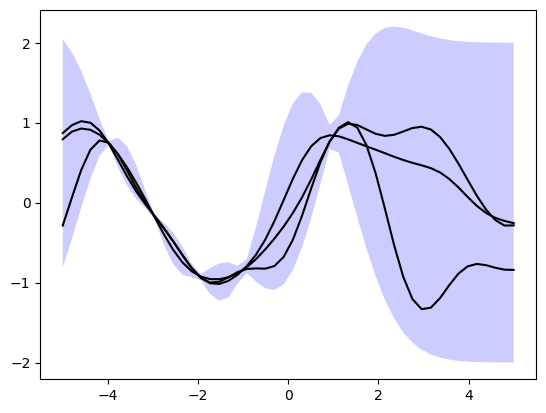

In [5]:
gp.compute_posterior()
gp.generate_plots(X_test,3)  #samples from GP posterior